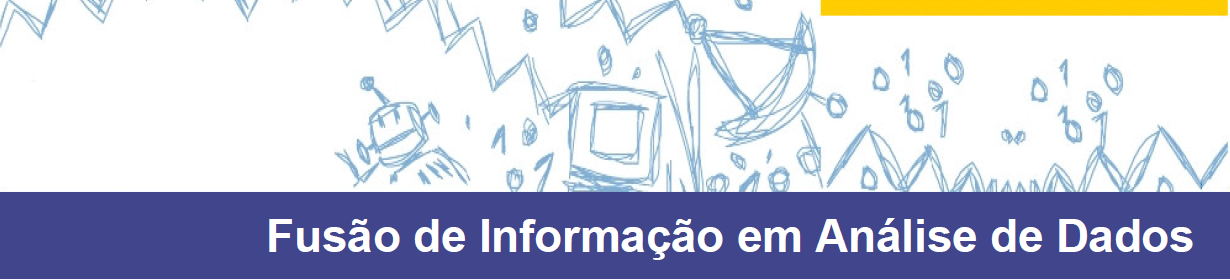
### Ficha Prática nº 3 de FIAD 2022 - Uma Resolução usando Python
Alberto Cardoso e Jorge Henriques © DEI2021/2022

Objetivo: Pretende-se continuar a exemplificar a aplicação da fusão de dados de sensores para obter a estimativa dos estados de um Veículo Aéreo Não Tripulado (VANT), usando um filtro de Kalman.

**Exercícios**
	
Considerando o dataset disponibilizado com os dados adquiridos com os sensores de uma UMI (com 6 graus de liberdade), efetue as seguintes tarefas:

**Exercício FP2.1.** Ler e representar os dados dos sensores (acelerómetros e giroscópios).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

In [2]:
def read_imu_data(csv_file):
    A = pd.read_csv(csv_file)  # read csv file with raw data

    t=A['t'].values.tolist()   # time stamp
    Ax=A['Ax'].values.tolist() # data from the accelerometers 
    Ay=A['Ay'].values.tolist()
    Az=A['Az'].values.tolist()
    Gx=A['Gx'].values.tolist() # data from the gyroscope
    Gy=A['Gy'].values.tolist()
    Gz=A['Gz'].values.tolist()
    return t, Ax, Ay, Az, Gx, Gy, Gz

In [3]:
# Read data from imu_dat.csv dataset
t,Ax,Ay,Az,Gx,Gy,Gz=read_imu_data('imu_data.csv')

# Average sampling period
# dt = 0.0185
dt = np.around(np.diff(t).mean(),4)
print('dt = ', dt)

dt =  0.0185


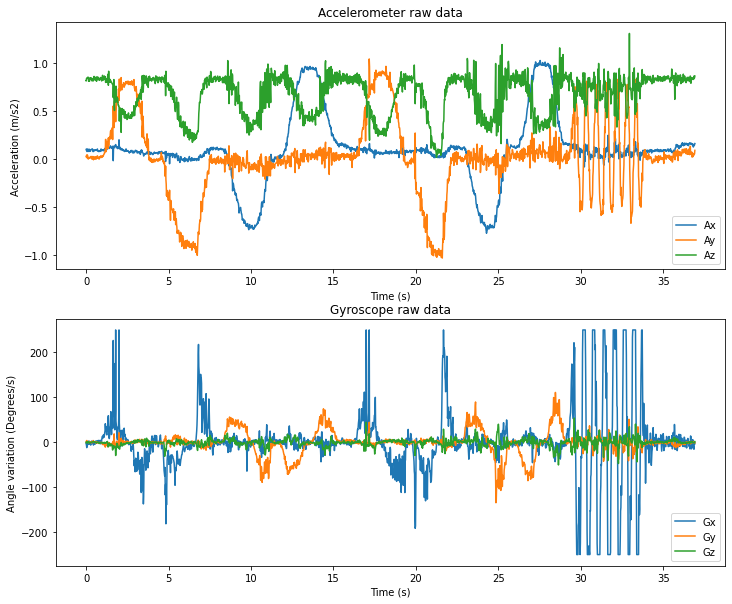

In [4]:
#--- Plot

plt.figure(figsize=(12,10))
plt.subplot(2, 1, 1)
plt.plot(t, Ax, label='Ax')
plt.plot(t, Ay, label='Ay')
plt.plot(t, Az, label='Az')
plt.title('Accelerometer raw data')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s2)')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(t, Gx, label='Gx')
plt.plot(t, Gy, label='Gy')
plt.plot(t, Gz, label='Gz')
plt.title('Gyroscope raw data')
plt.xlabel('Time (s)')
plt.ylabel('Angle variation (Degrees/s)')
plt.legend(loc='lower right')
plt.show()

<strong>Exercício FP2.2.</strong> Estimar e representar os ângulos *pitch* e *roll* apenas com base nos dados em bruto (raw data) dos acelerómetros.

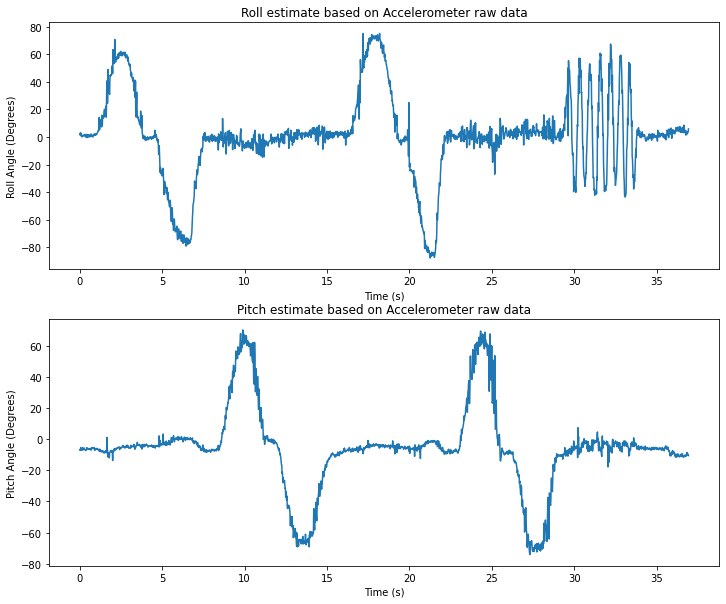

In [5]:
# Estimate and represent pitch and roll angles based only on raw data from accelerometers
phi_hat_acc = list()
theta_hat_acc = list()

for i in range(len(t)):
    phi_hat_acc.append(np.arctan2(Ay[i], np.sqrt(Ax[i]**2 + Az[i]**2)))
    theta_hat_acc.append(np.arctan2(-Ax[i], np.sqrt(Ay[i]**2 + Az[i]**2)))

#--- Plot

plt.figure(figsize=(12,10))
plt.subplot(2, 1, 1)
plt.plot(t, [a * 180.0 / np.pi for a in phi_hat_acc])
plt.title('Roll estimate based on Accelerometer raw data')
plt.xlabel('Time (s)')
plt.ylabel('Roll Angle (Degrees)')

plt.subplot(2, 1, 2)
plt.plot(t, [a * 180.0 / np.pi for a in theta_hat_acc])
plt.title('Pitch estimate based on Accelerometer raw data')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (Degrees)')
plt.show()

**Exercício FP2.3.** Aplicar um filtro passa-baixo (por exemplo um filtro de média móvel) às estimativas anteriores e representar os resultados obtidos, comparando com os não filtrados.

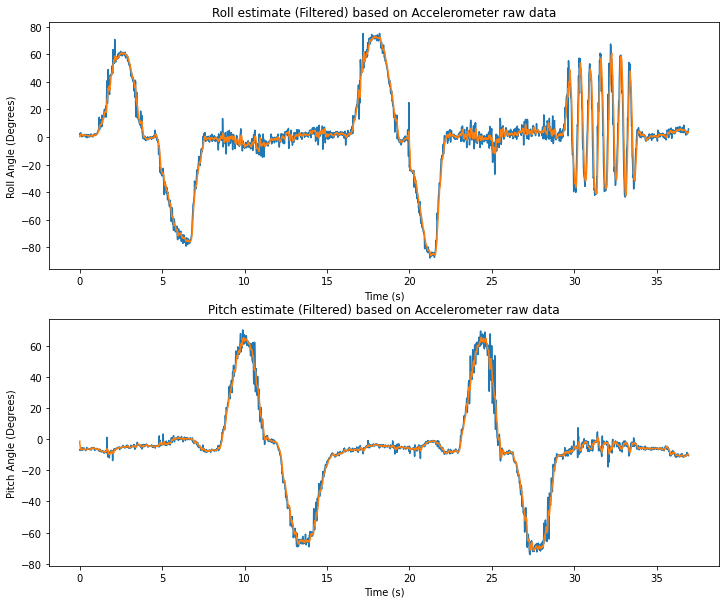

In [6]:
# Moving average filter (low-pass filter)

Npoint = 5
B = 1/Npoint*np.ones(Npoint)  # N-point moving average filter
phi_hat_acc_maf = signal.lfilter(B,1,phi_hat_acc)
theta_hat_acc_maf = signal.lfilter(B,1,theta_hat_acc)

#--- Plot

plt.figure(figsize=(12,10))
plt.subplot(2, 1, 1);
plt.plot(t, [a * 180.0 / np.pi for a in phi_hat_acc], t, [a * 180.0 / np.pi for a in phi_hat_acc_maf])
plt.title('Roll estimate (Filtered) based on Accelerometer raw data')
plt.xlabel('Time (s)')
plt.ylabel('Roll Angle (Degrees)')

plt.subplot(2, 1, 2);
plt.plot(t, [a * 180.0 / np.pi for a in theta_hat_acc], t, [a * 180.0 / np.pi for a in theta_hat_acc_maf])
plt.title('Pitch estimate (Filtered) based on Accelerometer raw data')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (Degrees)')
plt.show()

**Exercício FP2.4.** Simular a estimativa do ângulo *roll* por integração da variação desse ângulo, obtida a partir dos giroscópios, e representar o resultado comparando com o ângulo *roll* efetivo, sem ruído;

In [7]:
# Function to demonstrate the Gyroscopic Drift
def gyro_drift():
    # Simulation parameters
    N = 1000  # samples
    Ts = 0.01 # sampling period
    noise_std = 0.5

    # Time vector
    t = np.arange(0,N) * Ts

    # True states
    theta = np.exp(-t) * np.sin(2 * np.pi * t)
    theta_dot = np.exp(-t) * (2 * np.pi * np.cos(2 * np.pi * t) - np.sin(2 * np.pi * t))

    # Noisy gyro measurements
    theta_dot_noise = theta_dot + noise_std * np.random.standard_normal(N)

    # Integrate gyro measurements to get state estimate
    # Considering the initial state value as zero
    # Using the Euler's method for numerical integration of the ODE

    theta_hat = np.zeros(N)
    
    for i in range(1,N):
        theta_hat[i] = theta_hat[i - 1] + theta_dot_noise[i-1] * Ts

    plt.figure(figsize=(12,5))
    plt.plot(t, [a * 180.0 / np.pi for a in theta], label = 'True')
    plt.plot(t, [a * 180.0 / np.pi for a in theta_hat], label = 'Estimate')
    plt.xlabel('Time (s)')
    plt.ylabel('Theta (degrees)')
    plt.title('Gyro Drift')
    plt.legend(loc='upper right')
    plt.show()
    return

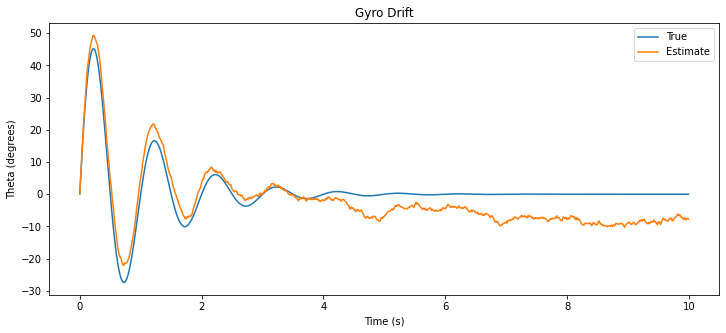

In [8]:
# Gyroscopic Drift Demonstration

gyro_drift()

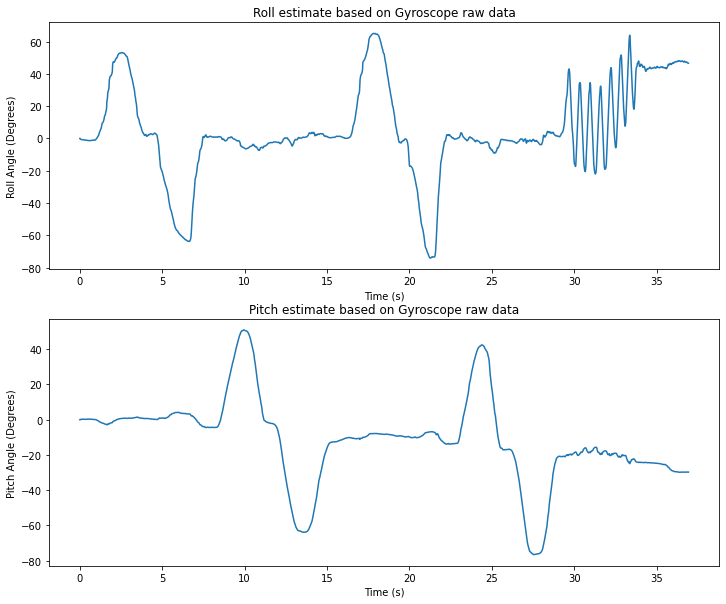

In [9]:
# Gyroscope only
# Considering the initial states value as zero
# Using the Euler's method for numerical integration of the ODEs

# Convert gyroscope measurements from degrees to radians
Gx_rad = [g * np.pi /180.0 for g in Gx]
Gy_rad = [g * np.pi /180.0 for g in Gy]
Gz_rad = [g * np.pi /180.0 for g in Gz]

phi_hat_gyr = np.zeros(len(t))
theta_hat_gyr = np.zeros(len(t))

for i in range(1,len(t)):
    p = Gx_rad[i]
    q = Gy_rad[i]
    r = Gz_rad[i]
   
    phi_hat   = phi_hat_gyr[i - 1]
    theta_hat = theta_hat_gyr[i - 1]
    
    phi_hat_gyr[i]   = phi_hat   + dt * (p + np.sin(phi_hat) * np.tan(theta_hat) * q + np.cos(phi_hat) * np.tan(theta_hat) * r)
    theta_hat_gyr[i] = theta_hat + dt * (np.cos(phi_hat) * q - np.sin(phi_hat) * r)

# Plot
plt.figure(figsize=(12,10))
plt.subplot(2, 1, 1)
plt.plot(t, [a * 180.0 / np.pi for a in phi_hat_gyr])
plt.title('Roll estimate based on Gyroscope raw data')
plt.xlabel('Time (s)')
plt.ylabel('Roll Angle (Degrees)')

plt.subplot(2, 1, 2)
plt.plot(t, [a * 180.0 / np.pi for a in theta_hat_gyr])
plt.title('Pitch estimate based on Gyroscope raw data')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (Degrees)')
plt.show()

**Exercício FP2.5.** Estimar e representar os ângulos *pitch* e *roll* com base na fusão dos dados dos sensores (acelerómetros e giroscópios) usando um filtro complementar (seguindo o método indicado anteriormente), fazendo variar o valor do parâmetro $α$. Discutir os resultados obtidos.

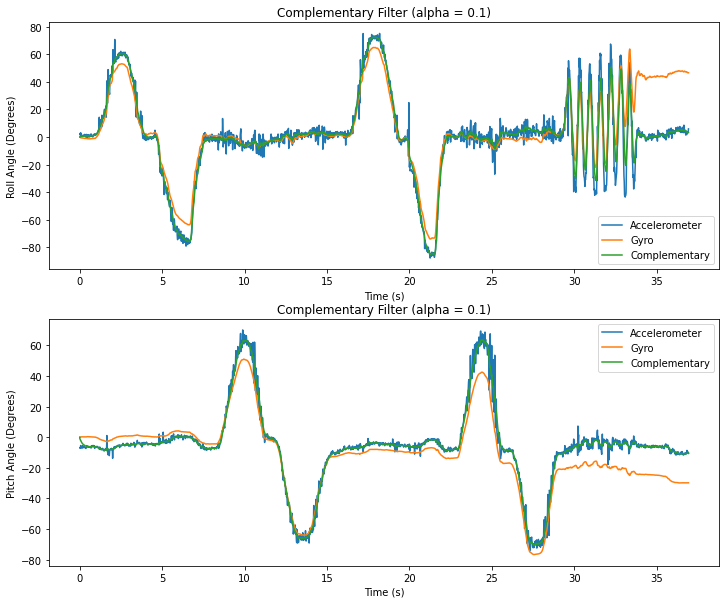

In [10]:
# Complementary Filter
# Considering the initial states value as zero
# Using the Euler's method for numerical integration of the ODEs

alpha = 0.1   # Complementary Filter parameter
#alpha = 0.4

phi_hat_complementary   = np.zeros(len(t))
theta_hat_complementary = np.zeros(len(t))

for i in range(1,len(t)):
    p = Gx_rad[i]
    q = Gy_rad[i]
    r = Gz_rad[i]
    
    phi_hat   = phi_hat_complementary[i - 1]
    theta_hat = theta_hat_complementary[i - 1]
    
    phi_hat_gyr_comp   = phi_hat   + dt * (p + np.sin(phi_hat) * np.tan(theta_hat) * q + np.cos(phi_hat) * np.tan(theta_hat) * r)
    theta_hat_gyr_comp = theta_hat + dt * (np.cos(phi_hat) * q - np.sin(phi_hat) * r)
       
    phi_hat_complementary[i]   = (1 - alpha) * phi_hat_gyr_comp   + alpha * phi_hat_acc[i]
    theta_hat_complementary[i] = (1 - alpha) * theta_hat_gyr_comp + alpha * theta_hat_acc[i]    

# Convert all estimates to degrees
phi_hat_acc_deg = [a * 180.0 / np.pi for a in phi_hat_acc]
theta_hat_acc_deg = [a * 180.0 / np.pi for a in theta_hat_acc]
phi_hat_gyr_deg = [a * 180.0 / np.pi for a in phi_hat_gyr]
theta_hat_gyr_deg = [a * 180.0 / np.pi for a in theta_hat_gyr]
phi_hat_complementary_deg = [a * 180.0 / np.pi for a in phi_hat_complementary]
theta_hat_complementary_deg = [a * 180.0 / np.pi for a in theta_hat_complementary]

# Plots

plt.figure(figsize=(12,10))
plt.subplot(2, 1, 1);
plt.plot(t, phi_hat_acc_deg, label='Accelerometer')
plt.plot(t, phi_hat_gyr_deg, label='Gyro')
plt.plot(t, phi_hat_complementary_deg, label='Complementary')
plt.legend(loc='lower right')
plt.xlabel('Time (s)')
plt.ylabel('Roll Angle (Degrees)')
plt.title('Complementary Filter (alpha = ' + str(alpha) + ')')

plt.subplot(2, 1, 2);
plt.plot(t, theta_hat_acc_deg, label='Accelerometer')
plt.plot(t, theta_hat_gyr_deg, label='Gyro')
plt.plot(t, theta_hat_complementary_deg, label='Complementary')
plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (Degrees)')
plt.title('Complementary Filter (alpha = ' + str(alpha) + ')')
plt.show()

**Exercício FP3.1.** Especificar o modelo do sistema e as matrizes das equações de um Filtro de *Kalman*.

In [11]:
# Representação do sistema no espaço de estados

A = np.array([[1.0, -dt, 0, 0],
              [0, 1.0, 0, 0],
              [0, 0, 1.0, -dt],
              [0, 0, 0, 1]])
B = np.transpose(np.array([[dt, 0, 0, 0],
              [0, 0, dt, 0]]))
C = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])
P = np.eye(4)
Q = np.eye(4)*0.01
R = np.eye(2)*10

**Exercício FP3.2.** Estimar e representar os ângulos *pitch* e *roll* com base na fusão dos dados dos sensores (acelerómetros e giroscópios) usando um Filtro de *Kalman*, fazendo variar as matrizes ***P***, ***Q*** e ***R***. Discutir os resultados obtidos.

In [12]:
# Kalman Filter
# Considering the initial states value as zero
# Using the Euler's method for numerical integration of the ODEs

state_estimate = np.transpose(np.array([[0, 0, 0, 0]]))

phi_hat_kalman   = np.zeros(len(t))
bias_phi_kalman   = np.zeros(len(t))
theta_hat_kalman = np.zeros(len(t))
bias_theta_kalman = np.zeros(len(t))


for i in range(1,len(t)):
    p = Gx_rad[i]
    q = Gy_rad[i]
    r = Gz_rad[i]
    
    phi_hat   = phi_hat_kalman[i - 1]
    theta_hat = theta_hat_kalman[i - 1]
    
    phi_dot   = p + np.sin(phi_hat) * np.tan(theta_hat) * q + np.cos(phi_hat) * np.tan(theta_hat) * r
    theta_dot = np.cos(phi_hat) * q - np.sin(phi_hat) * r
    
    # Predict
    state_estimate = A.dot(state_estimate) + B.dot(np.transpose(np.array([[phi_dot, theta_dot]])))
    P = A.dot(P).dot(np.transpose(A)) + Q
        
    # Update
    measurement = np.transpose(np.array([[phi_hat_acc[i], theta_hat_acc[i]]]))
    y_tilde = measurement - C.dot(state_estimate)
    S = R + C.dot(P.dot(np.transpose(C)))
    K = P.dot(np.transpose(C).dot(np.linalg.inv(S)))
    state_estimate = state_estimate + K.dot(y_tilde)
    P = (np.eye(4) - K.dot(C)).dot(P)

    phi_hat_kalman[i] = state_estimate[0]
    bias_phi_kalman[i] = state_estimate[1]
    theta_hat_kalman[i] = state_estimate[2]
    bias_theta_kalman[i] = state_estimate[3]

# Convert all estimates to degrees
phi_hat_acc_deg = [a * 180.0 / np.pi for a in phi_hat_acc]
theta_hat_acc_deg = [a * 180.0 / np.pi for a in theta_hat_acc]
phi_hat_gyr_deg = [a * 180.0 / np.pi for a in phi_hat_gyr]
theta_hat_gyr_deg = [a * 180.0 / np.pi for a in theta_hat_gyr]
phi_hat_complementary_deg = [a * 180.0 / np.pi for a in phi_hat_complementary]
theta_hat_complementary_deg = [a * 180.0 / np.pi for a in theta_hat_complementary]
phi_hat_kalman_deg = [a * 180.0 / np.pi for a in phi_hat_kalman]
theta_hat_kalman_deg = [a * 180.0 / np.pi for a in theta_hat_kalman]

**Exercício FP3.3.** Comparar graficamente os resultados obtidos com as abordagens de estimação dos estados do sistema considerados nesta ficha e na anterior. Comentar os resultados obtidos.

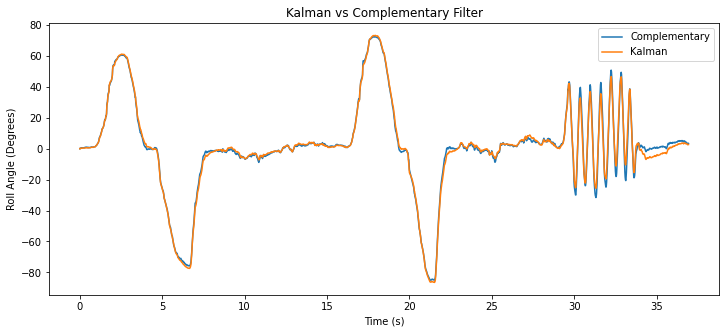

In [13]:
# Plots

plt.figure(figsize=(12,5))
plt.plot(t, phi_hat_complementary_deg, label='Complementary')
plt.plot(t, phi_hat_kalman_deg, label='Kalman')
plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.ylabel('Roll Angle (Degrees)')
plt.title('Kalman vs Complementary Filter')
plt.show()

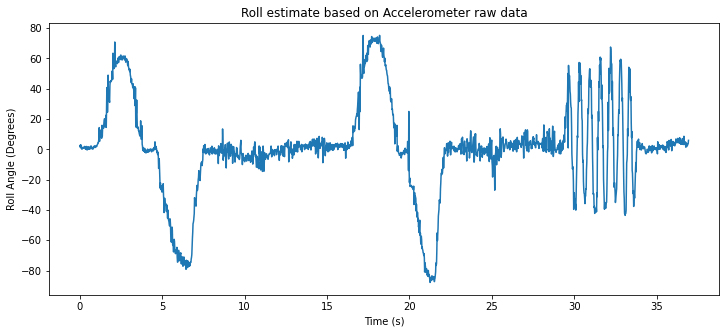

In [14]:
plt.figure(figsize=(12,5))
plt.plot(t, phi_hat_acc_deg)
plt.xlabel('Time (s)')
plt.ylabel('Roll Angle (Degrees)')
plt.title('Roll estimate based on Accelerometer raw data')
plt.show()

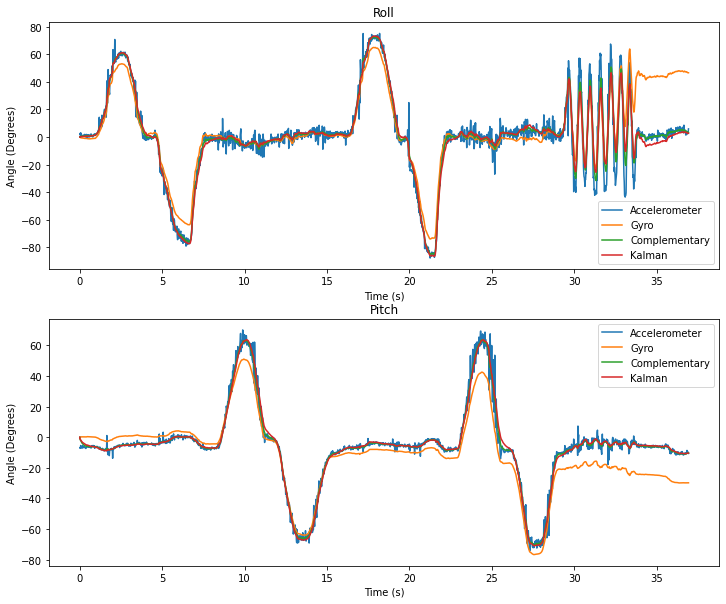

In [15]:
plt.figure(figsize=(12,10))
plt.subplot(2, 1, 1);
plt.plot(t, phi_hat_acc_deg, label='Accelerometer')
plt.plot(t, phi_hat_gyr_deg, label='Gyro')
plt.plot(t, phi_hat_complementary_deg, label='Complementary')
plt.plot(t, phi_hat_kalman_deg, label='Kalman')
plt.legend(loc='lower right')
plt.xlabel('Time (s)')
plt.ylabel('Angle (Degrees)')
plt.title('Roll')

plt.subplot(2, 1, 2);
plt.plot(t, theta_hat_acc_deg, label='Accelerometer')
plt.plot(t, theta_hat_gyr_deg, label='Gyro')
plt.plot(t, theta_hat_complementary_deg, label='Complementary')
plt.plot(t, theta_hat_kalman_deg, label='Kalman')
plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.ylabel('Angle (Degrees)')
plt.title('Pitch')
plt.show()